In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Colores para gráficos

LOW_DAMAGE_COLOR = "#fff25e"
MEDIUM_DAMAGE_COLOR = "#ffc45e"
SERIOUS_DAMAGE_COLOR = "#ff5e5e"
DAMAGE_COLOR_PALETTE = [LOW_DAMAGE_COLOR, MEDIUM_DAMAGE_COLOR, SERIOUS_DAMAGE_COLOR]

In [3]:
# Funciones para limpieza de datos

def set_categorical_columns(df):
    df_copy = df.copy()

    columns = [
        "land_surface_condition",
        "foundation_type",
        "roof_type",
        "ground_floor_type",
        "other_floor_type",
        "position",
        "plan_configuration",
        "legal_ownership_status",
    ]

    for column in columns:
        if column not in df:
            continue
        df_copy[column] = df[column].astype("category")

    return df_copy

def set_boolean_columns(df):
    df_copy = df.copy()
    
    for column in df:
        if column.startswith("has_"):
            df_copy[column] = df[column].astype(bool)
    
    return df_copy

In [4]:
# Lectura de datos

values = pd.read_csv("train_values.csv")
labels = pd.read_csv("train_labels.csv")
df = values.merge(labels, on="building_id")

## Análisis y limpieza del set de datos

Empezamos analizando los datos, para tener una idea preliminar de qué forma tienen.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 40 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  int64 
 1   geo_level_1_id                          260601 non-null  int64 
 2   geo_level_2_id                          260601 non-null  int64 
 3   geo_level_3_id                          260601 non-null  int64 
 4   count_floors_pre_eq                     260601 non-null  int64 
 5   age                                     260601 non-null  int64 
 6   area_percentage                         260601 non-null  int64 
 7   height_percentage                       260601 non-null  int64 
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260601 non-null 

Se puede ver que ninguna columna tiene valores nulos. Además, sabemos que varias columnas corresponden a variables categóricas y booleanas, por lo que podemos convertirlas al tipo correcto.

In [6]:
df = set_categorical_columns(df)
df = set_boolean_columns(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 40 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   building_id                             260601 non-null  int64   
 1   geo_level_1_id                          260601 non-null  int64   
 2   geo_level_2_id                          260601 non-null  int64   
 3   geo_level_3_id                          260601 non-null  int64   
 4   count_floors_pre_eq                     260601 non-null  int64   
 5   age                                     260601 non-null  int64   
 6   area_percentage                         260601 non-null  int64   
 7   height_percentage                       260601 non-null  int64   
 8   land_surface_condition                  260601 non-null  category
 9   foundation_type                         260601 non-null  category
 10  roof_type                       

## Distribución de los datos

Se puede ver cuántas edificicaciones hay por cada nivel de daño.

Text(0, 0.5, 'Cantidad')

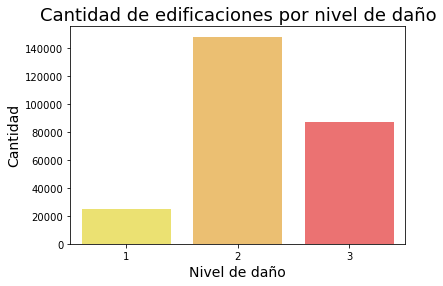

In [7]:
ax = sns.countplot(data=df, x="damage_grade", palette=DAMAGE_COLOR_PALETTE)
ax.set_title("Cantidad de edificaciones por nivel de daño", fontsize=18)
ax.set_xlabel("Nivel de daño", fontsize=14)
ax.set_ylabel("Cantidad", fontsize=14)

La mayoría de los edificios presentes en el set de datos tuvieron un nivel de daño 2, mientras que hay muy pocos con nivel 1 en comparación con los otros dos niveles. Esto implica un desbalance en los datos disponibles que podría ser importante tener en cuenta a la hora de sacar conclusiones.

## Correlación entre las distintas variables y el nivel de daño

Como primera aproximación para entender como influyen las distintas características de las edificaciones con el daño sufrido por el terremoto, podemos realizar un heatmap a partir de la matriz de correlación obtenida del dataframe.

Text(0.5, 1.0, 'Correlación entre las distintas variables y el nivel de daño')

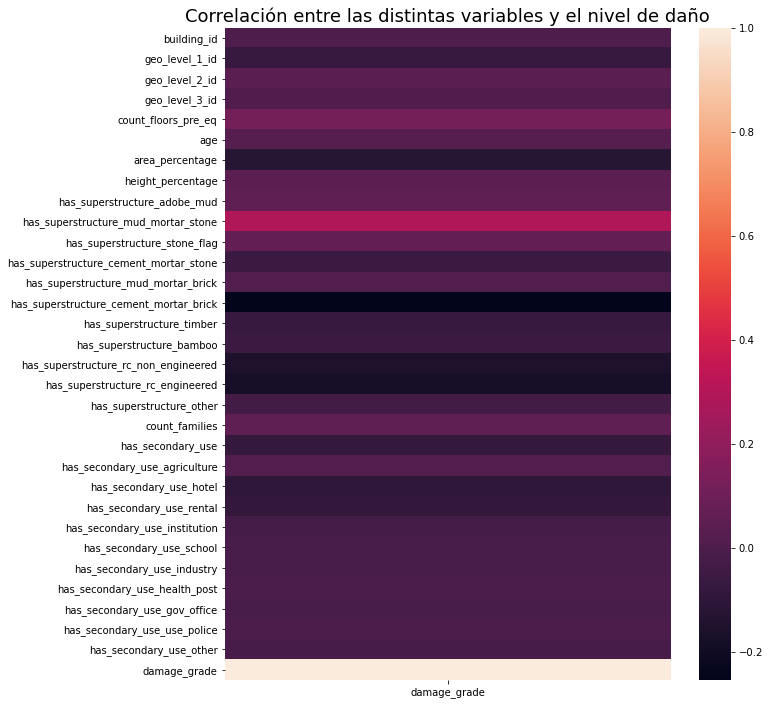

In [8]:
fig, ax = plt.subplots(figsize=(10, 12))
sns.heatmap(data=df.corr()["damage_grade"].to_frame(), ax=ax)
ax.set_title("Correlación entre las distintas variables y el nivel de daño", fontsize=18)

Se puede observar del gráfico que muchas variables tienen una correlación baja o nula con el nivel de daño que sufrió la edificación. Sin embargo, se ven algunas que pueden llegar a ser interesantes, como `count_floors_pre_eq` (correlación positiva) o `has_superstructure_cement_mortar_brick` (correlación negativa). Esto podría indicar que los edificios más altos sufrieron más daño, y por otro lado, los que fueron construidos con cemento y ladrillos mostraron mayor resistencia.

## Material usado en la construcción

Varias columnas del set de datos nos dan información sobre los materiales usados en las construcciones de las edificaciones. Esto puede ser una característica importante para determinar si un edificio sufrió un daño mayor o menor.

In [9]:
columns_translations = {
    "mud_mortar_stone": "Barro/piedra",
    "timber": "Timber",
    "adobe_mud": "Adobe/barro",
    "bamboo": "Bamboo",
    "cement_mortar_brick": "Cemento/ladrillos",
    "mud_mortar_brick": "Barro/ladrillos",
    "rc_non_engineered": "Concreto reforzado no diseñado",
    "rc_engineered": "Concreto reforzado diseñado",
    "stone_flag": "Piedra",
    "cement_mortar_stone": "Cemento/piedra",
    "other": "Otro",
}

In [10]:
superstructure_df = df[[c for c in df.columns if c.startswith("has_superstructure_")]]\
    .sum()\
    .sort_values(ascending=False)\
    .to_frame()\
    .reset_index()

superstructure_df.columns = ["superstructure", "count"]
superstructure_df["superstructure"] = superstructure_df["superstructure"]\
    .map(lambda x: columns_translations[x[len("has_superstructure_"):]])

Text(0.5, 1.0, 'Cantidad de edificaciones por material usado en la construcción')

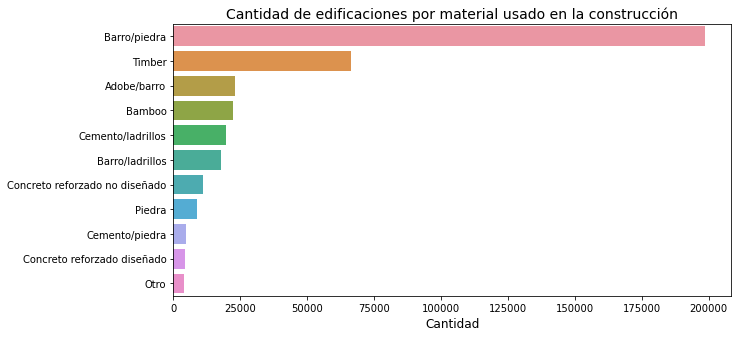

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=superstructure_df, y="superstructure", x="count", ax=ax)
ax.set_xlabel("Cantidad", fontsize=12)
ax.set_ylabel("")
ax.set_title("Cantidad de edificaciones por material usado en la construcción", fontsize=14)

### Construcciones con concreto

In [12]:
# Cantidad de edificaciones construidas con concreto (diseñado o no)

buildings_with_superstructure_rc =\
    df[(df["has_superstructure_rc_non_engineered"] == True) | (df["has_superstructure_rc_engineered"] == True)]

len(buildings_with_superstructure_rc)

15137

Text(0, 0.5, 'Cantidad')

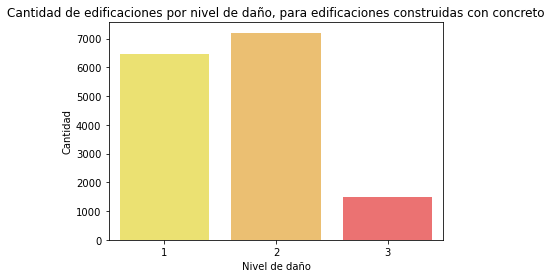

In [13]:
ax = sns.countplot(data=buildings_with_superstructure_rc, x="damage_grade", palette=DAMAGE_COLOR_PALETTE)
ax.set_title("Cantidad de edificaciones por nivel de daño, para edificaciones construidas con concreto")
ax.set_xlabel("Nivel de daño")
ax.set_ylabel("Cantidad")

### Construcciones con barro y piedra

In [14]:
buildings_with_superstructure_mud_mortar_stone =\
    df[(df["has_superstructure_mud_mortar_stone"] == True) & (df["has_superstructure_adobe_mud"] == True)]

len(buildings_with_superstructure_mud_mortar_stone)

7921

Text(0, 0.5, 'Cantidad')

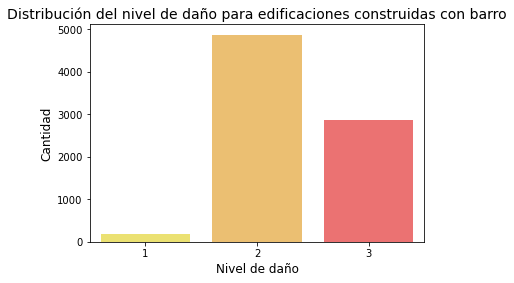

In [15]:
ax = sns.countplot(data=buildings_with_superstructure_mud_mortar_stone, x="damage_grade", palette=DAMAGE_COLOR_PALETTE)
ax.set_title("Distribución del nivel de daño para edificaciones construidas con barro", fontsize=14)
ax.set_xlabel("Nivel de daño", fontsize=12)
ax.set_ylabel("Cantidad", fontsize=12)

Text(0, 0.5, 'Cantidad')

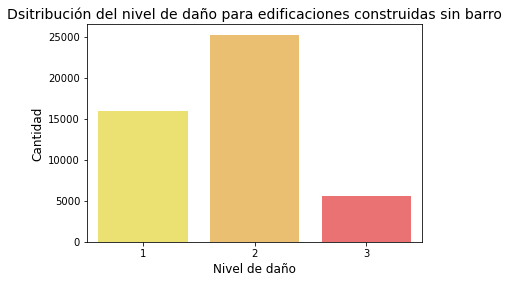

In [16]:
ax = sns.countplot(data=df[(df["has_superstructure_mud_mortar_stone"] == False) & (df["has_superstructure_adobe_mud"] == False)], x="damage_grade", palette=DAMAGE_COLOR_PALETTE)
ax.set_title("Dsitribución del nivel de daño para edificaciones construidas sin barro", fontsize=14)
ax.set_xlabel("Nivel de daño", fontsize=12)
ax.set_ylabel("Cantidad", fontsize=12)

### Construcciones con cemento y piedra

Text(0, 0.5, 'Cantidad')

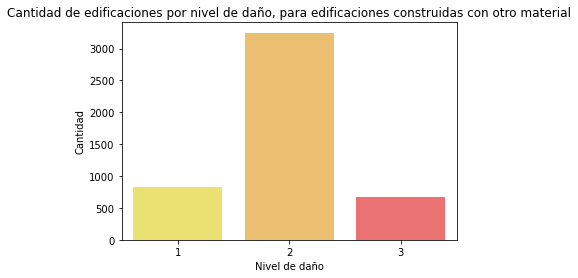

In [17]:
ax = sns.countplot(data=df[df["has_superstructure_cement_mortar_stone"] == True], x="damage_grade", palette=DAMAGE_COLOR_PALETTE)
ax.set_title("Cantidad de edificaciones por nivel de daño, para edificaciones construidas con otro material")
ax.set_xlabel("Nivel de daño")
ax.set_ylabel("Cantidad")

### Construcciones con otro material

In [18]:
# Cantidad de edificaciones construidas con otro tipo de material

buildings_with_superstructure_other =\
    df[df["has_superstructure_other"] == 1]

len(buildings_with_superstructure_other)

3905

Text(0, 0.5, 'Cantidad')

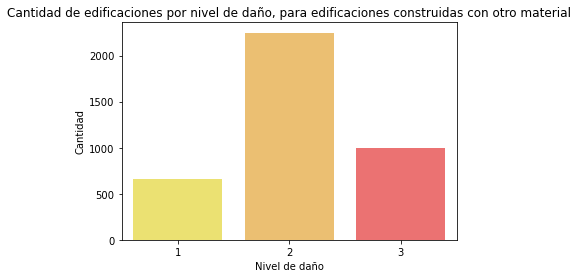

In [19]:
ax = sns.countplot(data=buildings_with_superstructure_other, x="damage_grade", palette=DAMAGE_COLOR_PALETTE)
ax.set_title("Cantidad de edificaciones por nivel de daño, para edificaciones construidas con otro material")
ax.set_xlabel("Nivel de daño")
ax.set_ylabel("Cantidad")

En el set de datos, hay muchas más edificaciones construidas con concreto que con otro tipo de material. Sin embargo, podemos observar de los gráficos que las construidas con concreto parecen tener una tendencia a sufrir un daño menor.

## Cantidad de familias por edificación

In [20]:
df["count_families"].value_counts(normalize=True)

1    0.867667
0    0.080053
2    0.043338
3    0.006915
4    0.001493
5    0.000399
6    0.000084
7    0.000027
9    0.000015
8    0.000008
Name: count_families, dtype: float64

In [21]:
df["count_families"].describe()

count    260601.000000
mean          0.983949
std           0.418389
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           9.000000
Name: count_families, dtype: float64

Text(0.5, 1.0, 'Distribución de la cantidad de familias por edificación')

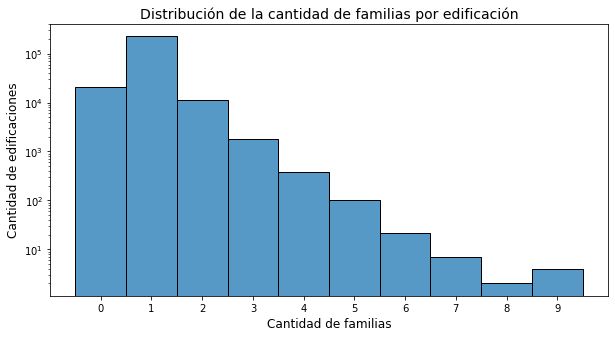

In [22]:
_, ax = plt.subplots(figsize=(10, 5))
plt.xticks(df["count_families"].value_counts().keys())
ax.set_yscale("log")
sns.histplot(data=df, x="count_families", discrete=True, ax=ax)
ax.set_xlabel("Cantidad de familias", fontsize=12)
ax.set_ylabel("Cantidad de edificaciones", fontsize=12)
ax.set_title("Distribución de la cantidad de familias por edificación", fontsize=14)

## Usos secundarios de las edificaciones

Text(0.5, 1.0, 'Proporciones de edificios con y sin uso secundario')

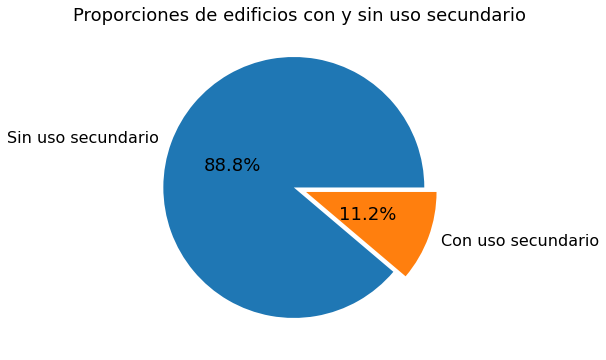

In [23]:
pie, ax = plt.subplots(figsize=[10,6])
labels = df["has_secondary_use"].value_counts().keys()
patches, texts, autotexts = plt.pie(
    x=df["has_secondary_use"].value_counts(),
    autopct="%.1f%%",
    explode=[.05, .05],
    labels=labels,
    pctdistance=0.5
)

for text in texts:
    text.set_fontsize(16)
    
    if text.get_text() == "False":
        text.set_text("Sin uso secundario")
    elif text.get_text() == "True":
        text.set_text("Con uso secundario")

for text in autotexts:
    text.set_fontsize(18)

ax.set_title("Proporciones de edificios con y sin uso secundario", fontsize=18)